Import of the libraries that we will use at the whole project

In [2]:
import spacy
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
from sentence_splitter import SentenceSplitter
import evaluate
import gensim.downloader as api
import numpy as np
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

Definition of the text and the sentences 

In [3]:
sentence1 = "Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets" 
sentence2 = "Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives"
text1 = "Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. Hope you too, to enjoy it as my deepest wishes. Thank your message to show our words to the doctor, as his next contract checking, to all of us. I got this message to see the approved message. In fact, I have received the message from the professor, to show me, this, a couple of days ago. I am very appreciated the full support of the professor, for our Springer proceedings publication."
text2 = "“During our final discuss, I told him about the new submission — the one we were waiting since last autumn, but the updates was confusing as it not included the full feedback from reviewer or maybe editor? Anyway, I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link came finally last week, I think. Also, kindly remind me please, if the doctor still plan for the acknowledgments section edit before he sending again. Because I didn’t see that part final yet, or maybe I missed, I apologize if so. Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets"

Assigment 1

Question A

In [4]:
def get_synonym(word):
    synonyms = []
    for syn in wordnet.synsets(word, pos=wordnet.ADJ):
        for lemma in syn.lemmas():
            if lemma.name().lower() != word.lower():
                synonyms.append(lemma.name().replace('_', ' '))
    if synonyms:
        return synonyms[0]  
    else:
        return word  

In [5]:
def replace_adjectives(sentence):
    doc = nlp(sentence)
    new_tokens = []
    for token in doc:
        if token.pos_ == "ADJ":
            new_word = get_synonym(token.text)
            new_tokens.append(new_word)
        else:
            new_tokens.append(token.text)
    return " ".join(new_tokens)

In [6]:
new_sentence1 = replace_adjectives(sentence1)
new_sentence2 = replace_adjectives(sentence2)
print("Original:", sentence1, sentence2)
print("Modified:", new_sentence1, new_sentence2)

Original: Overall, let us make sure all are safe and celebrate the outcome with strong coffee and future targets Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives
Modified: Overall , let us make certain all are dependable and celebrate the outcome with potent coffee and next targets Today is our dragon boat festival , in our Taiwanese culture , to celebrate it with all dependable and outstanding in our lives


Question B

In [7]:
paraphrase_Pegasus_pipeline = pipeline(
    "text2text-generation",
    model="tuner007/pegasus_paraphrase", 
    device=0 if torch.cuda.is_available() else -1)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [8]:
splitter = SentenceSplitter(language='en')
sentence_list1 = splitter.split(text1)
sentence_list2 = splitter.split(text2)

paraphrased_sentences1 = paraphrase_Pegasus_pipeline(sentence_list1, max_length=60, num_return_sequences=1)
paraphrased_sentences2 = paraphrase_Pegasus_pipeline(sentence_list2, max_length=60, num_return_sequences=1)
paraphrased_text1_model1 = " ".join([result['generated_text'] for result in paraphrased_sentences1])
paraphrased_text2_model1 = " ".join([result['generated_text'] for result in paraphrased_sentences2])

print(paraphrased_text1_model1)
print(paraphrased_text2_model1)


Our Chinese culture has a dragon boat festival that is celebrated today. Hope you enjoy it as much as I did. Your message was appreciated by the doctor, as his next contract check, to all of us. I saw the approved message after getting this message. I received the message from the professor a couple of days ago. The professor supported the Springer proceedings publication.
I told him about the new submission we were waiting for, but the updates were confusing as they didn't include the full feedback from the reviewer or editor. I think the team tried their best for paper and cooperation despite the recent delay and less communication. We should be thankful for the acceptance and efforts until the Springer link came last week, I think. If the doctor still plans for the acknowledgments section to be edited before he sends again, please remind me. I apologize if I missed that part final. Let's make sure all are safe and celebrate the outcome with coffee and targets.


In [9]:
model_name2 = "eugenesiow/bart-paraphrase"

paraphrase_pipeline2 = pipeline(
    "text2text-generation", 
    model=model_name2, 
    device=0 if torch.cuda.is_available() else -1
)

paraphrased_text1_model2 = paraphrase_pipeline2(
    text1, 
    max_length=300, 
    min_length=100, 
    num_return_sequences=1, 
    no_repeat_ngram_size=3 , 
    do_sample=False
)[0]['generated_text']

paraphrased_text2_model2 = paraphrase_pipeline2(
    text2, 
    max_length=300, 
    min_length=100, 
    num_return_sequences=1, 
    no_repeat_ngram_size=3 , 
    do_sample=False
    
)[0]['generated_text']
print("Original Text:\n", text1,text2)
print("\nParaphrased Text:\n", paraphrased_text1_model2,paraphrased_text2_model2)

Device set to use cpu


Original Text:
 Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. Hope you too, to enjoy it as my deepest wishes. Thank your message to show our words to the doctor, as his next contract checking, to all of us. I got this message to see the approved message. In fact, I have received the message from the professor, to show me, this, a couple of days ago. I am very appreciated the full support of the professor, for our Springer proceedings publication. “During our final discuss, I told him about the new submission — the one we were waiting since last autumn, but the updates was confusing as it not included the full feedback from reviewer or maybe editor? Anyway, I believe the team, although bit delay and less communication at recent days, they really tried best for paper and cooperation. We should be grateful, I mean all of us, for the acceptance and efforts until the Springer link came finally last week, I think. Also, kindl

In [10]:

model_name3 = "google/flan-t5-large"

paraphrase_pipeline = pipeline(
    "text2text-generation", 
    model=model_name3, 
    device=0 if torch.cuda.is_available() else -1
)
paraphrased_text1_model3 = paraphrase_pipeline(
    text1, 
    max_length=300, 
    min_length=100, 
    num_return_sequences=1, 
    no_repeat_ngram_size=3 , 
    do_sample=False
)[0]['generated_text']
paraphrased_text2_model3 = paraphrase_pipeline(
    text2, 
    max_length=300, 
    min_length=100, 
    num_return_sequences=1, 
    no_repeat_ngram_size=3 , 
    do_sample=False
)[0]['generated_text']

print("Original Text:\n", text1)
print("\nParaphrased Text:\n", paraphrased_text1_model3,paraphrased_text2_model3)


Device set to use cpu


Original Text:
 Today is our dragon boat festival, in our Chinese culture, to celebrate it with all safe and great in our lives. Hope you too, to enjoy it as my deepest wishes. Thank your message to show our words to the doctor, as his next contract checking, to all of us. I got this message to see the approved message. In fact, I have received the message from the professor, to show me, this, a couple of days ago. I am very appreciated the full support of the professor, for our Springer proceedings publication.

Paraphrased Text:
 Thank you for your message. I am very grateful for your support. I hope you can enjoy the dragon boat festival with all safe and great in your lives. Hope you too, to enjoy it with all my deepest wishes. Thank you to show our words to the doctor, as his next contract checking, to all of us. I got this message to see the approved message. In fact, I have received the message from the professor, to show me, this, a couple of days ago. I is very appreciated the

Question C

In [11]:
# For the perfect text we asked OpenAI (chatGPT) to reconstruct the text that you given to us 
perfectTextViaGPT_1="Today is the Dragon Boat Festival , a meaningful celebration in Chinese culture . We honor it as a time to reflect on safety , well-being , and positive wishes in our lives . I hope you too can share in this spirit and receive my heartfelt greetings . Thank you for forwarding our message to the doctor in preparation for reviewing his upcoming contract — this matters to all of us . I have already seen the approved message . In fact , the professor kindly shared it with me a few days ago . I truly appreciate his full support regarding our Springer proceedings publication. It means a lot to us all ."
perfectTextViaGPT_2="During our final discussion , I informed him about the new submission — the one we’ve been awaiting since last autumn . However , the recent update was somewhat unclear , as it didn’t seem to include full feedback from the reviewer or perhaps the editor . That said , I do believe the team has done its best, despite the delays and reduced communication in recent days . We should all be thankful for the acceptance and the efforts made — especially now that the Springer link was finally shared last week. Also , please kindly remind me whether the doctor still intends to revise the acknowledgments section before resubmitting . I haven’t seen the final version of that part yet — or I may have missed it . If so , I apologize . Overall , let’s make sure everything is in order , and take a moment to celebrate the outcome — perhaps with a strong coffee and fresh goals for the future ."

In [12]:
bertscore = evaluate.load("bertscore")
paraphrased_texts_List1=[paraphrased_text1_model1, paraphrased_text1_model2, paraphrased_text1_model3]

In [13]:
print("Comparison between the reconstructed and the perfect for the text 1")
for i, paraphrase in enumerate(paraphrased_texts_List1):
    results1 = bertscore.compute(
        predictions=[paraphrase], 
        references=[perfectTextViaGPT_1],       
        lang="en"
    )
    print(f"Paraphrase {i+1} - F1 Score: {results1['f1'][0]:.4f}")

print("Comparison between the reconstructed and the perfect for the text 1")

paraphrased_texts_List2=[paraphrased_text2_model1, paraphrased_text2_model2, paraphrased_text2_model3]
for i, paraphrase in enumerate(paraphrased_texts_List2):
    results2 = bertscore.compute(
        predictions=[paraphrase], 
        references=[perfectTextViaGPT_2],       
        lang="en"
    )
    print(f"Paraphrase {i+1} - F1 Score: {results2['f1'][0]:.4f}")

Comparison between the reconstructed and the perfect for the text 1


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Paraphrase 1 - F1 Score: 0.8782
Paraphrase 2 - F1 Score: 0.8749
Paraphrase 3 - F1 Score: 0.8720
Comparison between the reconstructed and the perfect for the text 1
Paraphrase 1 - F1 Score: 0.8918
Paraphrase 2 - F1 Score: 0.8872
Paraphrase 3 - F1 Score: 0.8183


Assigment 2

Loading the models we need for the assigment , first time might need some extra time

In [14]:
word2vec_model = api.load('word2vec-google-news-300') 
glove_model = api.load('glove-wiki-gigaword-100')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [15]:
def preprocess_and_embed(sentence, model, stop_words, stemmer):
    tokens = word_tokenize(sentence.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    stemmed_tokens = [stemmer.stem(t) for t in tokens]
    
    word_embeddings = {}
    for word in stemmed_tokens:
        if word in model:
            word_embeddings[word] = model[word]
        else:
            original_word = [t for t in tokens if stemmer.stem(t) == word]
            if original_word and original_word[0] in model:
                word_embeddings[word] = model[original_word[0]]
    return word_embeddings

In [16]:
def full_similarity_matrix(embed1, embed2):
    sims = {}
    for w1, v1 in embed1.items():
        max_sim = -1
        most_similar_word = None
        for w2, v2 in embed2.items():
            sim = cosine_similarity([v1], [v2])[0][0]
            if sim > max_sim:
                max_sim = sim
                most_similar_word = w2
        sims[w1] = (most_similar_word, max_sim)
    return sims

In [17]:
def average_cosine_similarity(embed1, embed2):
    if not embed1 or not embed2:
        return 0.0
    sims = []
    for v1 in embed1.values():
        max_sim = max([cosine_similarity([v1], [v2])[0][0] for v2 in embed2.values()])
        sims.append(max_sim)
    return np.mean(sims)

In [18]:
def visualize_embeddings(embeddings1, embeddings2, method='pca', title=''):
    all_words = list(embeddings1.keys()) + list(embeddings2.keys())
    all_vectors = list(embeddings1.values()) + list(embeddings2.values())
    
    X = np.array(all_vectors)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=5, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(10, 6))
    for i, word in enumerate(all_words):
        color = 'blue' if i < len(embeddings1) else 'red'
        plt.scatter(X_reduced[i, 0], X_reduced[i, 1], c=color)
        plt.text(X_reduced[i, 0]+0.01, X_reduced[i, 1]+0.01, word, fontsize=9)

    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Original (A)', markerfacecolor='blue', markersize=10)
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Reconstructed (B)', markerfacecolor='red', markersize=10)
    
    plt.legend(handles=[blue_patch, red_patch])
    plt.title(title or f"Word Embeddings Visualization using {method.upper()}")
    plt.grid(True)
    plt.show()


 For each word Cosine Similarities:
'today' -> 'today': similarity = 1.0000
'dragon' -> 'dragon': similarity = 1.0000
'boat' -> 'boat': similarity = 1.0000
'festiv' -> 'festiv': similarity = 1.0000
'chines' -> 'chines': similarity = 1.0000
'cultur' -> 'cultur': similarity = 1.0000
'celebr' -> 'celebr': similarity = 1.0000
'safe' -> 'today': similarity = 0.1849
'great' -> 'us': similarity = 0.4295
'live' -> 'enjoy': similarity = 0.3775
'hope' -> 'hope': similarity = 1.0000
'enjoy' -> 'enjoy': similarity = 1.0000
'deepest' -> 'hope': similarity = 0.1615
'wish' -> 'hope': similarity = 0.5262
'thank' -> 'appreci': similarity = 0.3882
'messag' -> 'messag': similarity = 1.0000
'show' -> 'get': similarity = 0.2406
'word' -> 'messag': similarity = 0.4307
'doctor' -> 'doctor': similarity = 1.0000
'next' -> 'next': similarity = 1.0000
'contract' -> 'contract': similarity = 1.0000
'check' -> 'check': similarity = 1.0000
'us' -> 'us': similarity = 1.0000
'got' -> 'get': similarity = 0.7245
'see' 

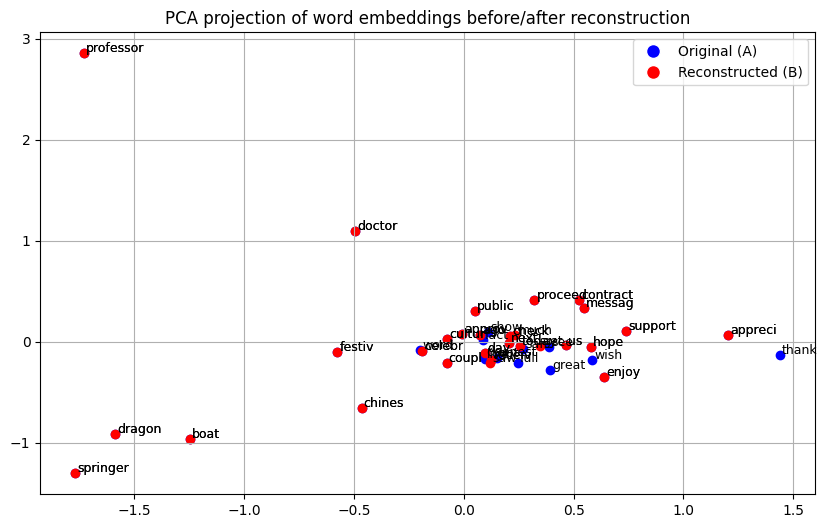

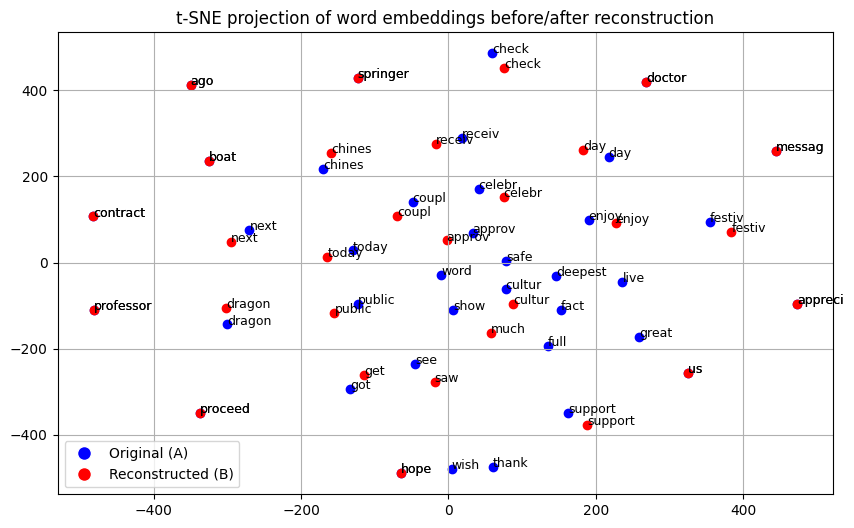


 For each word Cosine Similarities:
'today' -> 'today': similarity = 1.0000
'dragon' -> 'dragon': similarity = 1.0000
'boat' -> 'boat': similarity = 1.0000
'festiv' -> 'festiv': similarity = 1.0000
'chines' -> 'chines': similarity = 1.0000
'cultur' -> 'cultur': similarity = 1.0000
'celebr' -> 'celebr': similarity = 0.7790
'safe' -> 'get': similarity = 0.6047
'great' -> 'much': similarity = 0.7477
'live' -> 'day': similarity = 0.6053
'hope' -> 'hope': similarity = 1.0000
'enjoy' -> 'enjoy': similarity = 1.0000
'deepest' -> 'hope': similarity = 0.3076
'wish' -> 'hope': similarity = 0.7899
'thank' -> 'messag': similarity = 0.5944
'messag' -> 'messag': similarity = 1.0000
'show' -> 'day': similarity = 0.6564
'word' -> 'messag': similarity = 0.6558
'doctor' -> 'doctor': similarity = 1.0000
'next' -> 'next': similarity = 1.0000
'contract' -> 'contract': similarity = 1.0000
'check' -> 'check': similarity = 1.0000
'us' -> 'us': similarity = 1.0000
'got' -> 'get': similarity = 0.8843
'see' -> 

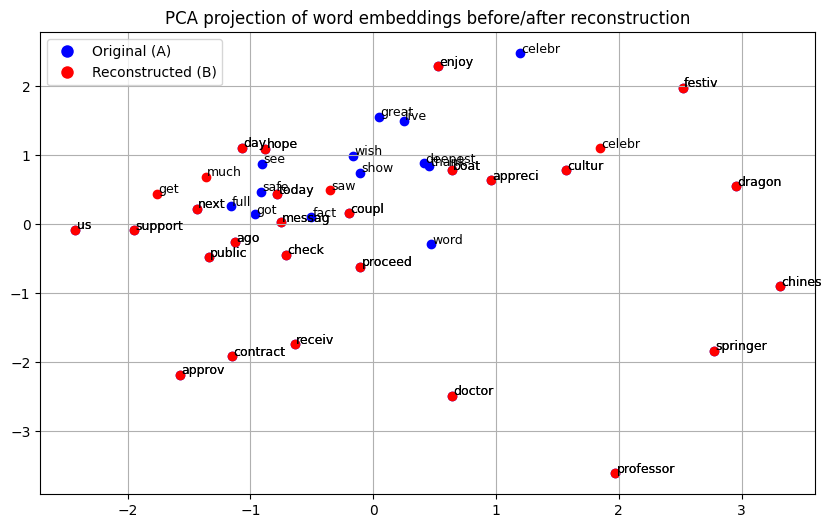

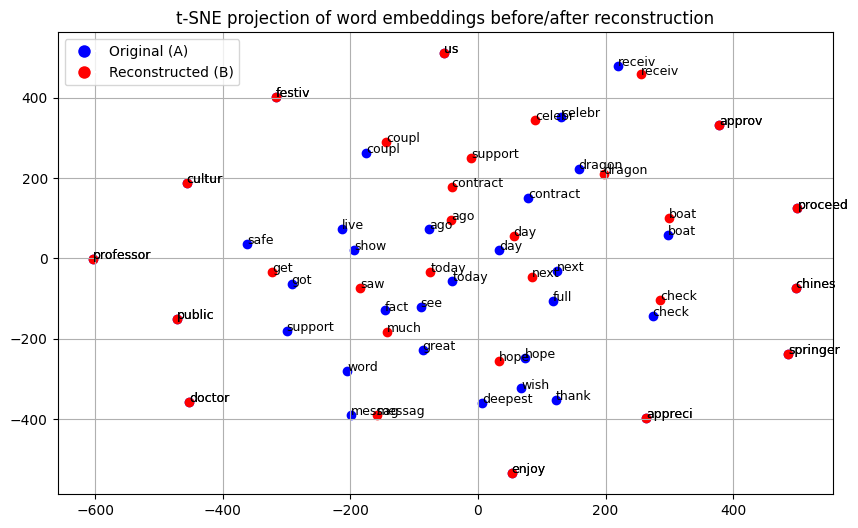


 For each word Cosine Similarities:
'today' -> 'today': similarity = 1.0000
'dragon' -> 'dragon': similarity = 1.0000
'boat' -> 'boat': similarity = 1.0000
'festiv' -> 'festiv': similarity = 1.0000
'chines' -> 'chines': similarity = 1.0000
'cultur' -> 'cultur': similarity = 1.0000
'celebr' -> 'celebr': similarity = 1.0000
'safe' -> 'safe': similarity = 1.0000
'great' -> 'great': similarity = 1.0000
'live' -> 'live': similarity = 1.0000
'hope' -> 'hope': similarity = 1.0000
'enjoy' -> 'enjoy': similarity = 1.0000
'deepest' -> 'deepest': similarity = 1.0000
'wish' -> 'wish': similarity = 1.0000
'thank' -> 'thank': similarity = 1.0000
'messag' -> 'messag': similarity = 1.0000
'show' -> 'show': similarity = 1.0000
'word' -> 'word': similarity = 1.0000
'doctor' -> 'doctor': similarity = 1.0000
'next' -> 'next': similarity = 1.0000
'contract' -> 'contract': similarity = 1.0000
'check' -> 'check': similarity = 1.0000
'us' -> 'great': similarity = 0.4295
'got' -> 'got': similarity = 1.0000
's

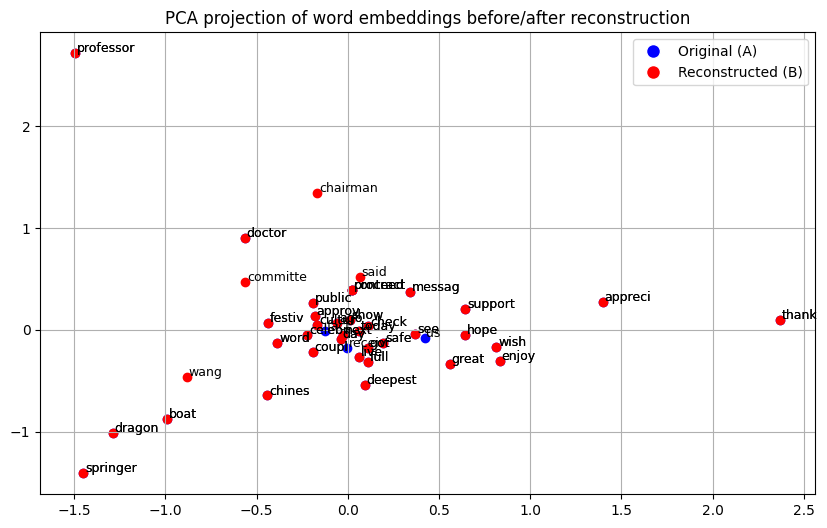

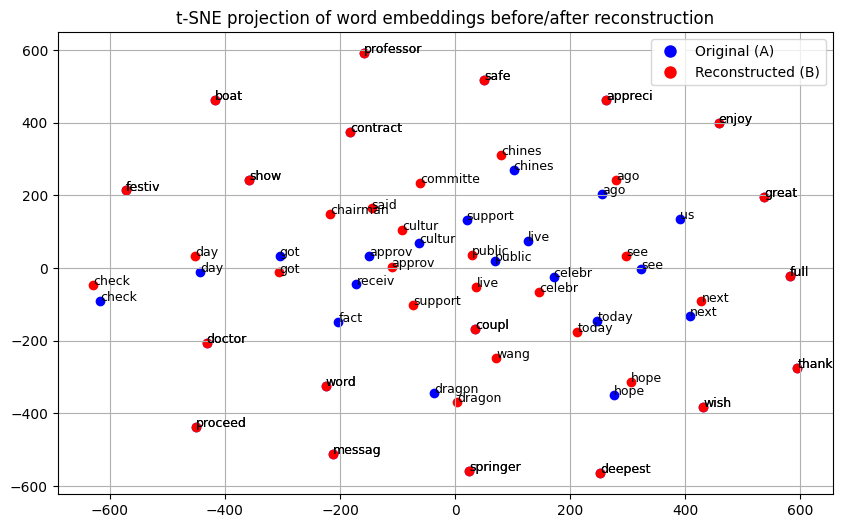


 For each word Cosine Similarities:
'today' -> 'today': similarity = 1.0000
'dragon' -> 'dragon': similarity = 1.0000
'boat' -> 'boat': similarity = 1.0000
'festiv' -> 'festiv': similarity = 1.0000
'chines' -> 'chines': similarity = 1.0000
'cultur' -> 'cultur': similarity = 1.0000
'celebr' -> 'celebr': similarity = 1.0000
'safe' -> 'safe': similarity = 1.0000
'great' -> 'great': similarity = 1.0000
'live' -> 'live': similarity = 1.0000
'hope' -> 'hope': similarity = 1.0000
'enjoy' -> 'enjoy': similarity = 1.0000
'deepest' -> 'deepest': similarity = 1.0000
'wish' -> 'wish': similarity = 1.0000
'thank' -> 'thank': similarity = 1.0000
'messag' -> 'messag': similarity = 1.0000
'show' -> 'show': similarity = 1.0000
'word' -> 'word': similarity = 1.0000
'doctor' -> 'doctor': similarity = 1.0000
'next' -> 'next': similarity = 1.0000
'contract' -> 'contract': similarity = 1.0000
'check' -> 'check': similarity = 1.0000
'us' -> 'see': similarity = 0.6511
'got' -> 'got': similarity = 1.0000
'see

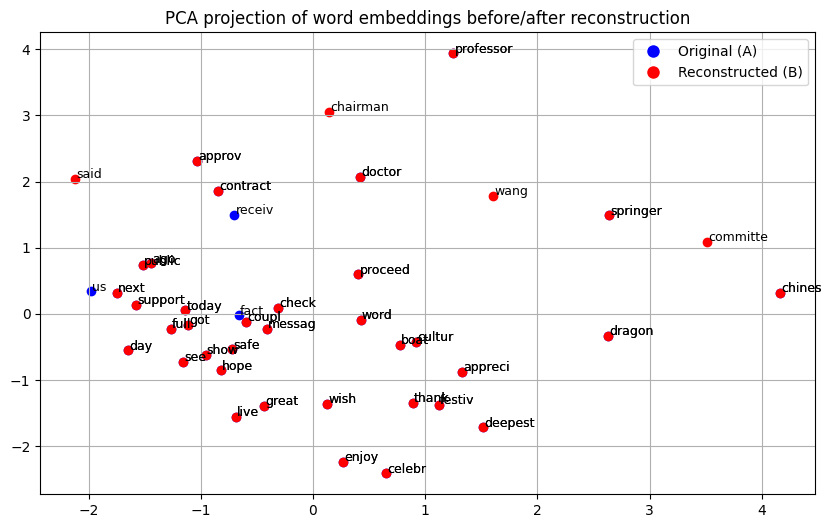

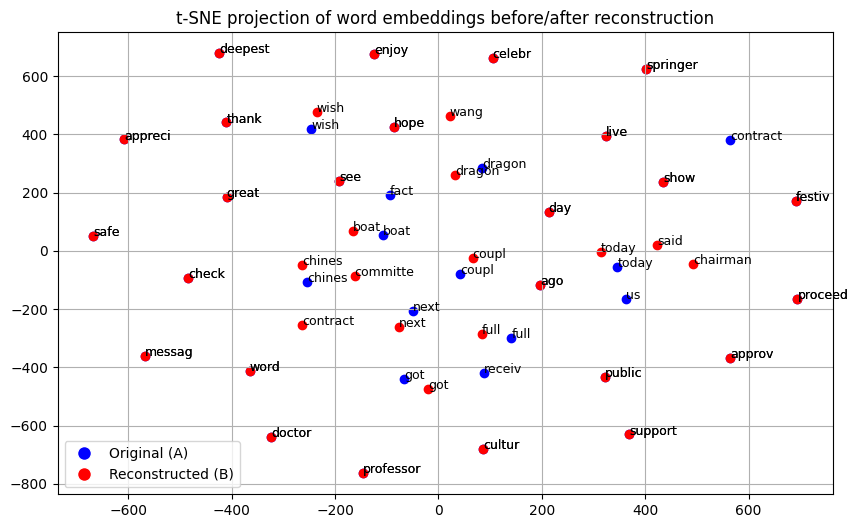


 For each word Cosine Similarities:
'today' -> 'day': similarity = 0.4033
'dragon' -> 'dragon': similarity = 1.0000
'boat' -> 'boat': similarity = 1.0000
'festiv' -> 'festiv': similarity = 1.0000
'chines' -> 'boat': similarity = 0.2956
'cultur' -> 'approv': similarity = 0.4403
'celebr' -> 'approv': similarity = 0.3541
'safe' -> 'safe': similarity = 1.0000
'great' -> 'great': similarity = 1.0000
'live' -> 'live': similarity = 1.0000
'hope' -> 'hope': similarity = 1.0000
'enjoy' -> 'enjoy': similarity = 1.0000
'deepest' -> 'deepest': similarity = 1.0000
'wish' -> 'wish': similarity = 1.0000
'thank' -> 'thank': similarity = 1.0000
'messag' -> 'messag': similarity = 1.0000
'show' -> 'show': similarity = 1.0000
'word' -> 'word': similarity = 1.0000
'doctor' -> 'doctor': similarity = 1.0000
'next' -> 'next': similarity = 1.0000
'contract' -> 'contract': similarity = 1.0000
'check' -> 'check': similarity = 1.0000
'us' -> 'us': similarity = 1.0000
'got' -> 'got': similarity = 1.0000
'see' -> 

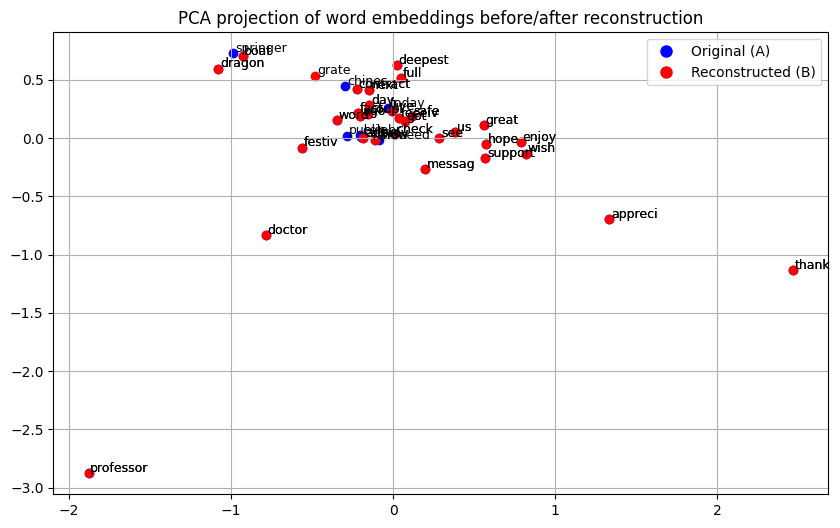

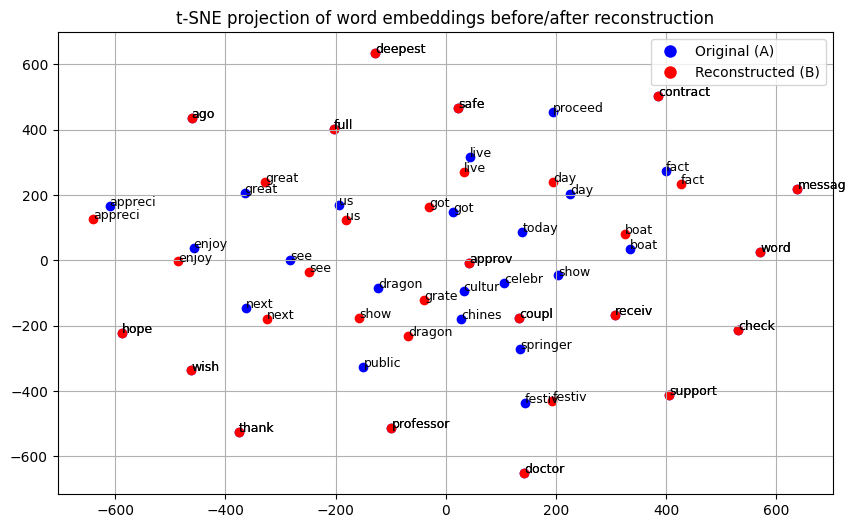


 For each word Cosine Similarities:
'today' -> 'see': similarity = 0.7700
'dragon' -> 'dragon': similarity = 1.0000
'boat' -> 'boat': similarity = 1.0000
'festiv' -> 'festiv': similarity = 1.0000
'chines' -> 'grate': similarity = 0.2222
'cultur' -> 'fact': similarity = 0.5280
'celebr' -> 'day': similarity = 0.5995
'safe' -> 'safe': similarity = 1.0000
'great' -> 'great': similarity = 1.0000
'live' -> 'live': similarity = 1.0000
'hope' -> 'hope': similarity = 1.0000
'enjoy' -> 'enjoy': similarity = 1.0000
'deepest' -> 'deepest': similarity = 1.0000
'wish' -> 'wish': similarity = 1.0000
'thank' -> 'thank': similarity = 1.0000
'messag' -> 'messag': similarity = 1.0000
'show' -> 'show': similarity = 1.0000
'word' -> 'word': similarity = 1.0000
'doctor' -> 'doctor': similarity = 1.0000
'next' -> 'next': similarity = 1.0000
'contract' -> 'contract': similarity = 1.0000
'check' -> 'check': similarity = 1.0000
'us' -> 'us': similarity = 1.0000
'got' -> 'got': similarity = 1.0000
'see' -> 'see

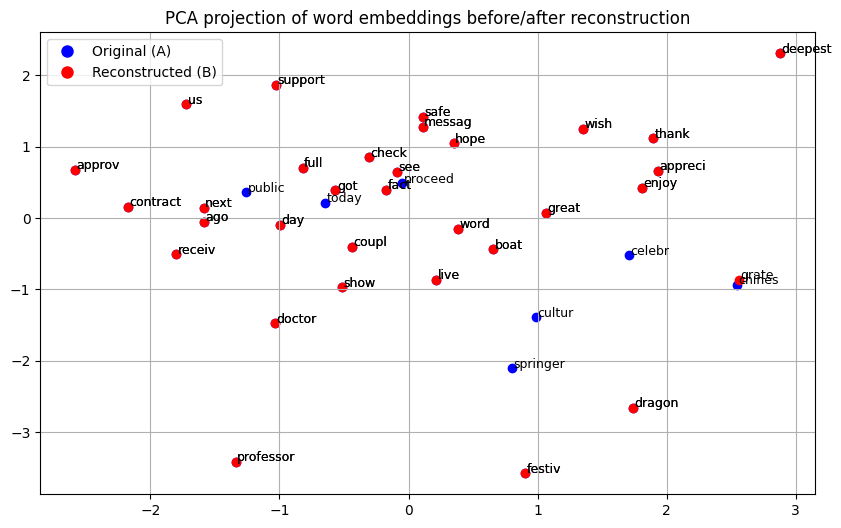

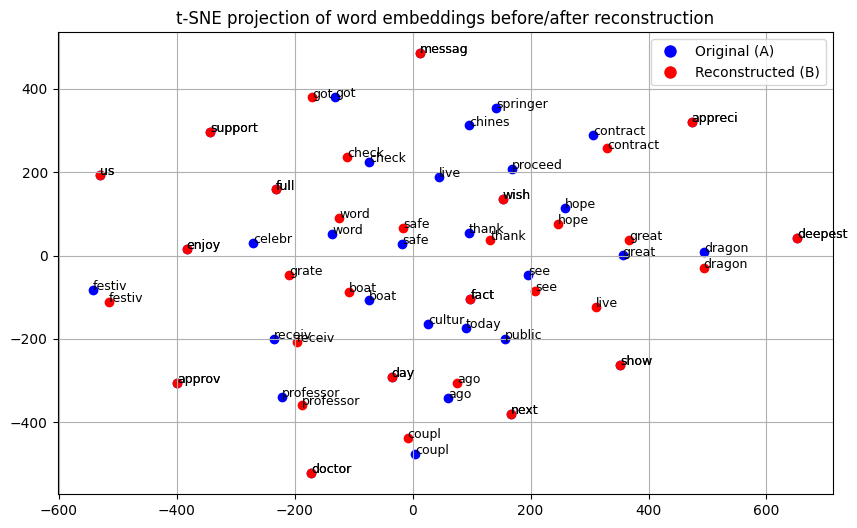

In [37]:
for paraphrasedText in paraphrased_texts_List1:
    for model,name in [(word2vec_model, "Word-2-vec"),(glove_model, "Glove")]:
        original_embeddings = preprocess_and_embed(text1, model, stop_words, stemmer)
        reconstructed_embeddings = preprocess_and_embed(paraphrasedText, model, stop_words, stemmer)
        print("\n For each word Cosine Similarities:")
        similarity_map = full_similarity_matrix(original_embeddings, reconstructed_embeddings)
        for word, (closest_word, sim) in similarity_map.items():
            print(f"'{word}' -> '{closest_word}': similarity = {sim:.4f}")
        sentence_similarity = average_cosine_similarity(original_embeddings, reconstructed_embeddings)
        print(f"\n Average Cosine Similarity between sentences with {name}: {sentence_similarity:.4f}")
        visualize_embeddings(
            original_embeddings, 
            reconstructed_embeddings, 
            method='pca', 
            title='PCA projection of word embeddings before/after reconstruction'
        )
        visualize_embeddings(
            original_embeddings, 
            reconstructed_embeddings, 
            method='tsne', 
            title='t-SNE projection of word embeddings before/after reconstruction'
        )


 For each word Cosine Similarities:
'final' -> 'final': similarity = 1.0000
'discuss' -> 'review': similarity = 0.3651
'told' -> 'told': similarity = 1.0000
'new' -> 'new': similarity = 1.0000
'submiss' -> 'submiss': similarity = 1.0000
'one' -> 'best': similarity = 0.3445
'wait' -> 'wait': similarity = 1.0000
'sinc' -> 'despit': similarity = 0.2194
'last' -> 'last': similarity = 1.0000
'autumn' -> 'week': similarity = 0.4352
'updat' -> 'updat': similarity = 1.0000
'confus' -> 'confus': similarity = 1.0000
'includ' -> 'includ': similarity = 1.0000
'full' -> 'full': similarity = 1.0000
'feedback' -> 'feedback': similarity = 1.0000
'review' -> 'review': similarity = 1.0000
'mayb' -> 'coffe': similarity = 0.3435
'editor' -> 'editor': similarity = 1.0000
'anyway' -> 'think': similarity = 0.5645
'believ' -> 'commun': similarity = 0.3732
'team' -> 'team': similarity = 1.0000
'although' -> 'still': similarity = 0.5116
'bit' -> 'think': similarity = 0.4577
'delay' -> 'delay': similarity = 1.0

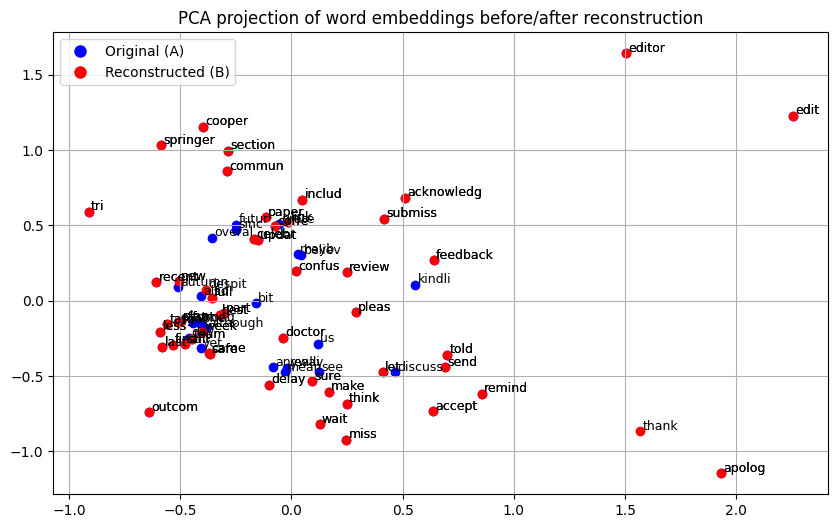

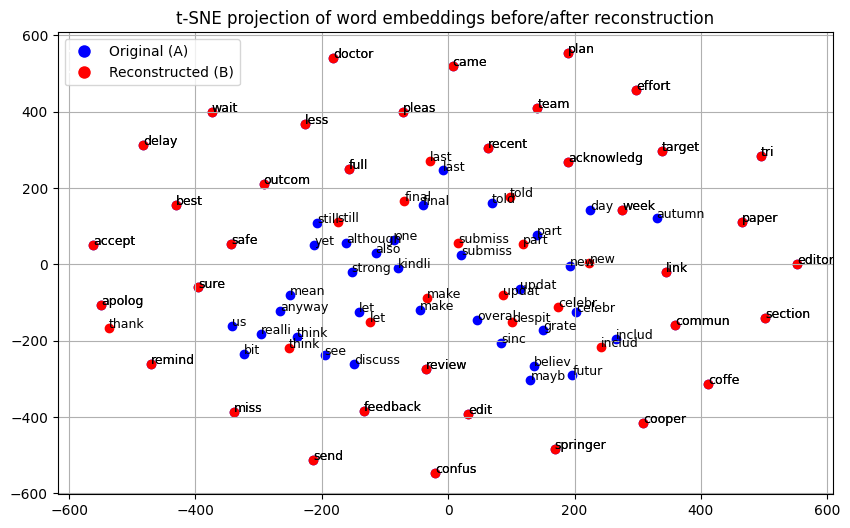


 For each word Cosine Similarities:
'final' -> 'final': similarity = 1.0000
'discuss' -> 'plan': similarity = 0.6237
'told' -> 'told': similarity = 1.0000
'new' -> 'new': similarity = 1.0000
'submiss' -> 'submiss': similarity = 1.0000
'one' -> 'last': similarity = 0.8040
'wait' -> 'wait': similarity = 1.0000
'sinc' -> 'commun': similarity = 0.3425
'last' -> 'last': similarity = 1.0000
'autumn' -> 'last': similarity = 0.4950
'updat' -> 'updat': similarity = 1.0000
'confus' -> 'confus': similarity = 1.0000
'includ' -> 'includ': similarity = 1.0000
'full' -> 'full': similarity = 1.0000
'feedback' -> 'feedback': similarity = 1.0000
'review' -> 'review': similarity = 1.0000
'mayb' -> 'think': similarity = 0.8834
'editor' -> 'editor': similarity = 1.0000
'anyway' -> 'sure': similarity = 0.7609
'believ' -> 'think': similarity = 0.8633
'team' -> 'team': similarity = 1.0000
'although' -> 'still': similarity = 0.8116
'bit' -> 'less': similarity = 0.6845
'delay' -> 'delay': similarity = 1.0000
'

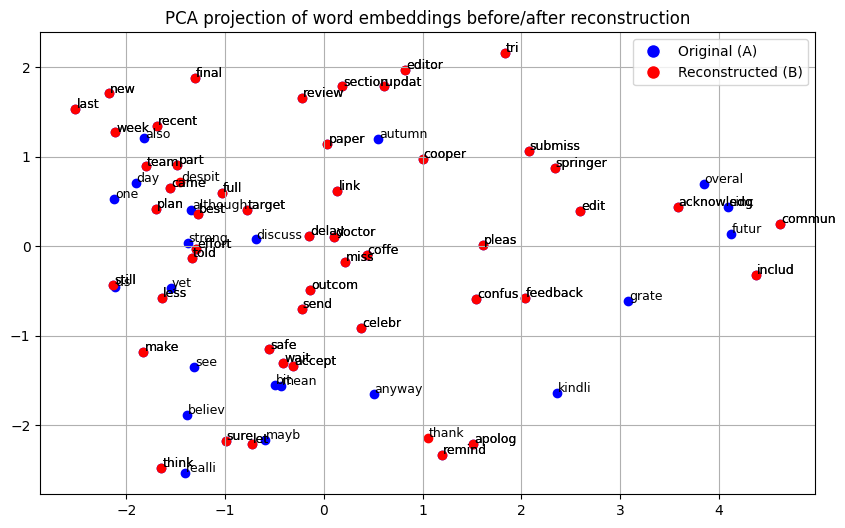

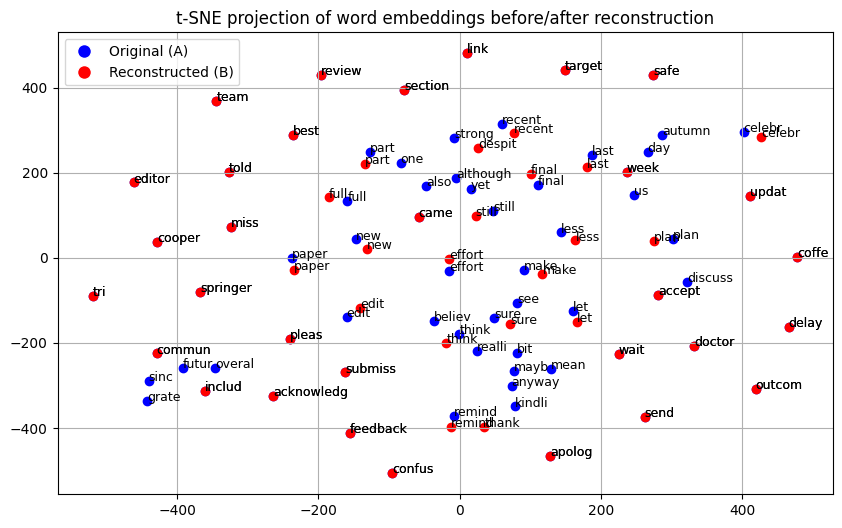


 For each word Cosine Similarities:
'final' -> 'final': similarity = 1.0000
'discuss' -> 'discuss': similarity = 1.0000
'told' -> 'told': similarity = 1.0000
'new' -> 'new': similarity = 1.0000
'submiss' -> 'submiss': similarity = 1.0000
'one' -> 'one': similarity = 1.0000
'wait' -> 'wait': similarity = 1.0000
'sinc' -> 'sinc': similarity = 1.0000
'last' -> 'last': similarity = 1.0000
'autumn' -> 'autumn': similarity = 1.0000
'updat' -> 'updat': similarity = 1.0000
'confus' -> 'confus': similarity = 1.0000
'includ' -> 'includ': similarity = 1.0000
'full' -> 'full': similarity = 1.0000
'feedback' -> 'feedback': similarity = 1.0000
'review' -> 'review': similarity = 1.0000
'mayb' -> 'mayb': similarity = 1.0000
'editor' -> 'editor': similarity = 1.0000
'anyway' -> 'realli': similarity = 0.5971
'believ' -> 'mayb': similarity = 0.5351
'team' -> 'effort': similarity = 0.2649
'although' -> 'yet': similarity = 0.5361
'bit' -> 'realli': similarity = 0.5512
'delay' -> 'wait': similarity = 0.457

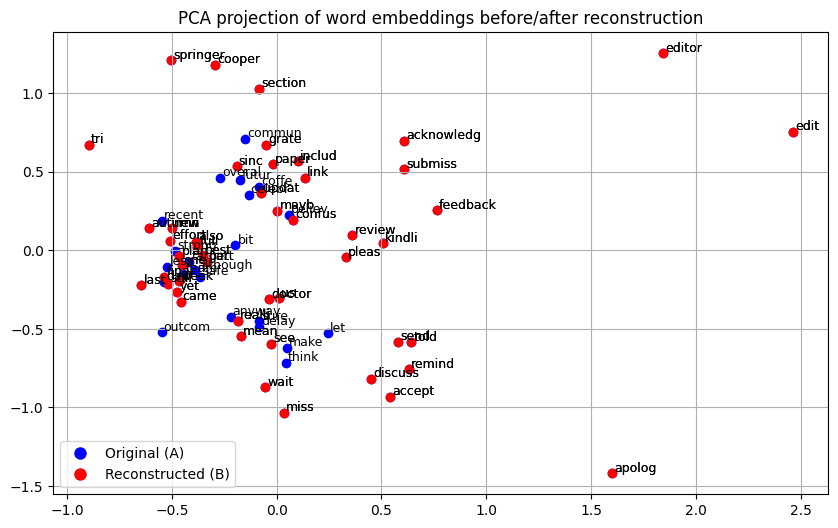

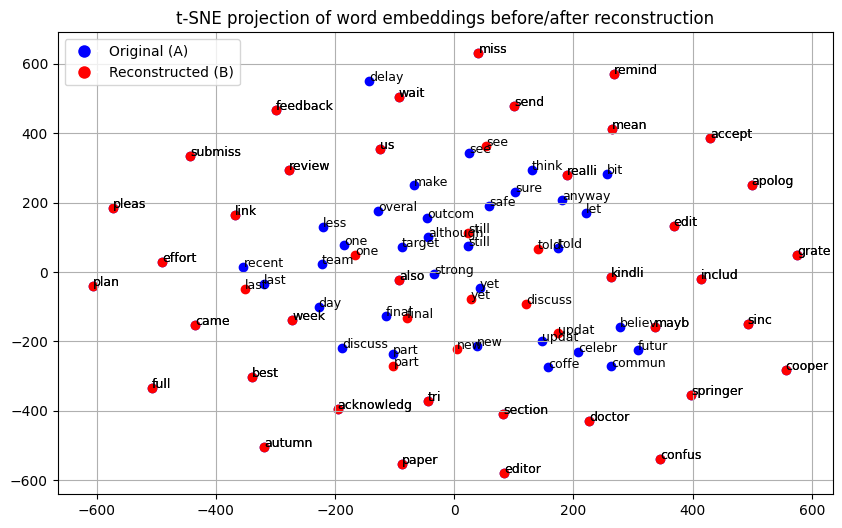


 For each word Cosine Similarities:
'final' -> 'final': similarity = 1.0000
'discuss' -> 'discuss': similarity = 1.0000
'told' -> 'told': similarity = 1.0000
'new' -> 'new': similarity = 1.0000
'submiss' -> 'submiss': similarity = 1.0000
'one' -> 'one': similarity = 1.0000
'wait' -> 'wait': similarity = 1.0000
'sinc' -> 'sinc': similarity = 1.0000
'last' -> 'last': similarity = 1.0000
'autumn' -> 'autumn': similarity = 1.0000
'updat' -> 'updat': similarity = 1.0000
'confus' -> 'confus': similarity = 1.0000
'includ' -> 'includ': similarity = 1.0000
'full' -> 'full': similarity = 1.0000
'feedback' -> 'feedback': similarity = 1.0000
'review' -> 'review': similarity = 1.0000
'mayb' -> 'mayb': similarity = 1.0000
'editor' -> 'editor': similarity = 1.0000
'anyway' -> 'mayb': similarity = 0.8314
'believ' -> 'see': similarity = 0.7819
'team' -> 'final': similarity = 0.6452
'although' -> 'yet': similarity = 0.8357
'bit' -> 'realli': similarity = 0.7546
'delay' -> 'plan': similarity = 0.5973
'l

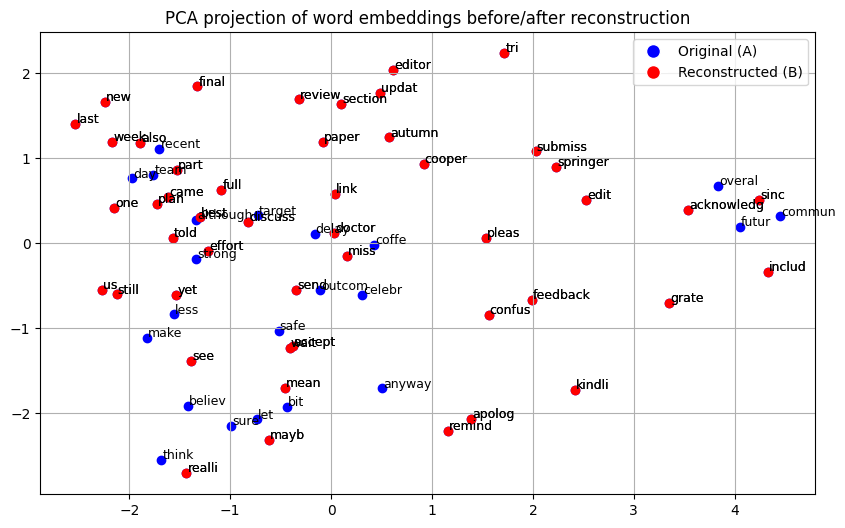

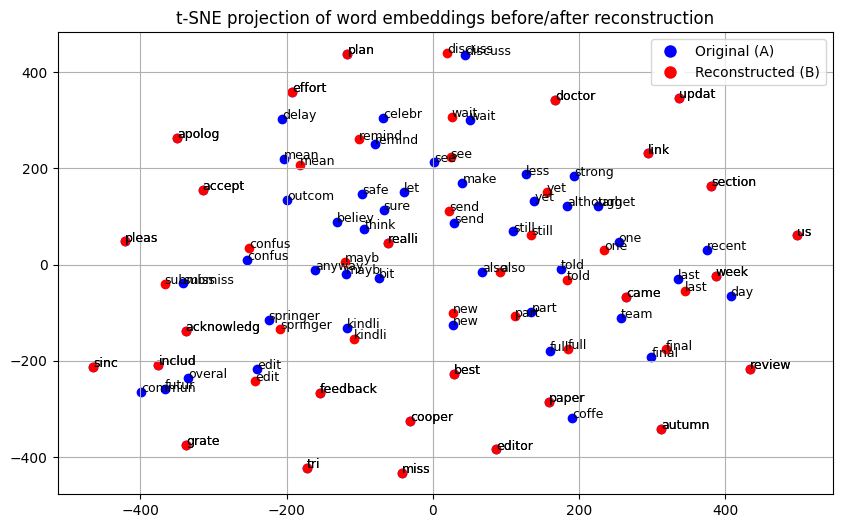


 For each word Cosine Similarities:
'final' -> 'outcom': similarity = 0.3300
'discuss' -> 'make': similarity = 0.2208
'told' -> 'let': similarity = 0.2731
'new' -> 'updat': similarity = 0.2298
'submiss' -> 'paper': similarity = 0.1772
'one' -> 'day': similarity = 0.3570
'wait' -> 'delay': similarity = 0.4576
'sinc' -> 'futur': similarity = 0.2877
'last' -> 'recent': similarity = 0.5172
'autumn' -> 'day': similarity = 0.3037
'updat' -> 'updat': similarity = 1.0000
'confus' -> 'bit': similarity = 0.2987
'includ' -> 'celebr': similarity = 0.2839
'full' -> 'sure': similarity = 0.2057
'feedback' -> 'realli': similarity = 0.2306
'review' -> 'read': similarity = 0.2749
'mayb' -> 'futur': similarity = 0.4113
'editor' -> 'read': similarity = 0.2517
'anyway' -> 'realli': similarity = 0.5971
'believ' -> 'futur': similarity = 0.3911
'team' -> 'us': similarity = 0.2564
'although' -> 'although': similarity = 1.0000
'bit' -> 'bit': similarity = 1.0000
'delay' -> 'delay': similarity = 1.0000
'less' -

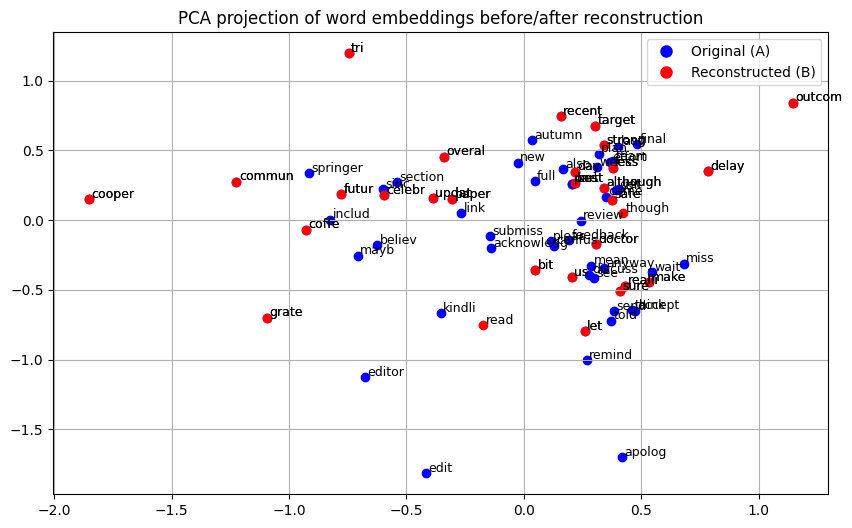

In [38]:
for paraphrasedText in paraphrased_texts_List2:
    for model,name in [(word2vec_model, "Word-2-vec"),(glove_model, "Glove")]:
        original_embeddings = preprocess_and_embed(text2, model, stop_words, stemmer)
        reconstructed_embeddings = preprocess_and_embed(paraphrasedText, model, stop_words, stemmer)
        print("\n For each word Cosine Similarities:")
        similarity_map = full_similarity_matrix(original_embeddings, reconstructed_embeddings)
        for word, (closest_word, sim) in similarity_map.items():
            print(f"'{word}' -> '{closest_word}': similarity = {sim:.4f}")
        sentence_similarity = average_cosine_similarity(original_embeddings, reconstructed_embeddings)
        print(f"\n Average Cosine Similarity between sentences with {name}: {sentence_similarity:.4f}")
        visualize_embeddings(
            original_embeddings, 
            reconstructed_embeddings, 
            method='pca', 
            title='PCA projection of word embeddings before/after reconstruction'
        )
        visualize_embeddings(
            original_embeddings, 
            reconstructed_embeddings, 
            method='tsne', 
            title='t-SNE projection of word embeddings before/after reconstruction'
        )